<h1 style="color: 	#365F93;"><strong>Chess winner prediction</strong></h1>

<h2 style="color: 	#80B1D3;"><strong>Librerias</strong></h2>

In [30]:
import pandas as pd
import sys
import os
sys.path.append(os.path.abspath('../src'))
from data_processing import load_chess_data, calculate_total_ply, extract_time_controls, normalize_features
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier


#Cargamos el data set y vemos su forma.
df_chess = load_chess_data("../data/raw/games.csv")

Dataset cargado exitosamente desde: ../data/raw/games.csv
Forma del dataset: (20058, 16)
         id  rated    created_at  last_move_at  turns victory_status winner  \
0  TZJHLljE  False  1.504210e+12  1.504210e+12     13      outoftime  white   
1  l1NXvwaE   True  1.504130e+12  1.504130e+12     16         resign  black   
2  mIICvQHh   True  1.504130e+12  1.504130e+12     61           mate  white   
3  kWKvrqYL   True  1.504110e+12  1.504110e+12     61           mate  white   
4  9tXo1AUZ   True  1.504030e+12  1.504030e+12     95           mate  white   

  increment_code       white_id  white_rating      black_id  black_rating  \
0           15+2       bourgris          1500          a-00          1191   
1           5+10           a-00          1322     skinnerua          1261   
2           5+10         ischia          1496          a-00          1500   
3           20+0  daniamurashov          1439  adivanov2009          1454   
4           30+3      nik221107          1523  adiv

<h2 style="color: 	#80B1D3;"><strong>Limpieza de datos</strong></h2>

In [2]:
#Hay que cambiar las dos porque son datos temporales y salen como float.
df_chess['created_at'] = pd.to_datetime(df_chess['created_at'], unit='ms', errors='coerce')
df_chess['last_move_at'] = pd.to_datetime(df_chess['last_move_at'], unit='ms', errors='coerce')

In [3]:
# Despues de una exploración de los datos vemos que hay datos que no tienen sentido como:
# Nos quedamos con partidas con al menos dos turnos, suele ser muy raro una rendicion instantanea, no nos sirve para el aprendizaje.
df_chess = df_chess[df_chess['turns'] >= 2]
# Hacemos una columna nueva que cuenta los datos separados por espacios, para sustituir otra columna que nos da muchos problemas.
df_chess['total_ply_from_moves'] = calculate_total_ply(df_chess['moves'])
#Antes de eliminar las columnas que no necesito voy a ver y eliminar duplicados.
df_chess.drop_duplicates(inplace=True)
# Lista de columnas a eliminar, son columnas con demasiados datos categóricos distintos, pueden darle problemas para apender a la maquina.
columns_to_drop = ['opening_eco', 'opening_name', 'opening_ply', 'id', 'white_id', 'black_id', 'moves', 'created_at', 'last_move_at']
# Eliminar las columnas
df_chess.drop(columns=columns_to_drop, inplace=True)

<h2 style="color: 	#80B1D3;"><strong>Feature engineering</strong></h2>

In [4]:
# Vamos a crear una columna nueva muy importante:
# La diferencia de nivel de los dos jugadores.
df_chess['rating_difference'] = df_chess['white_rating'] - df_chess['black_rating']
# Descomponemos una de las columnas categóricas con demasiados datos distintos a varias
# cloumnas numericas: 'initial_time_minutes' y 'increment_seconds'.
df_chess = extract_time_controls(df_chess)

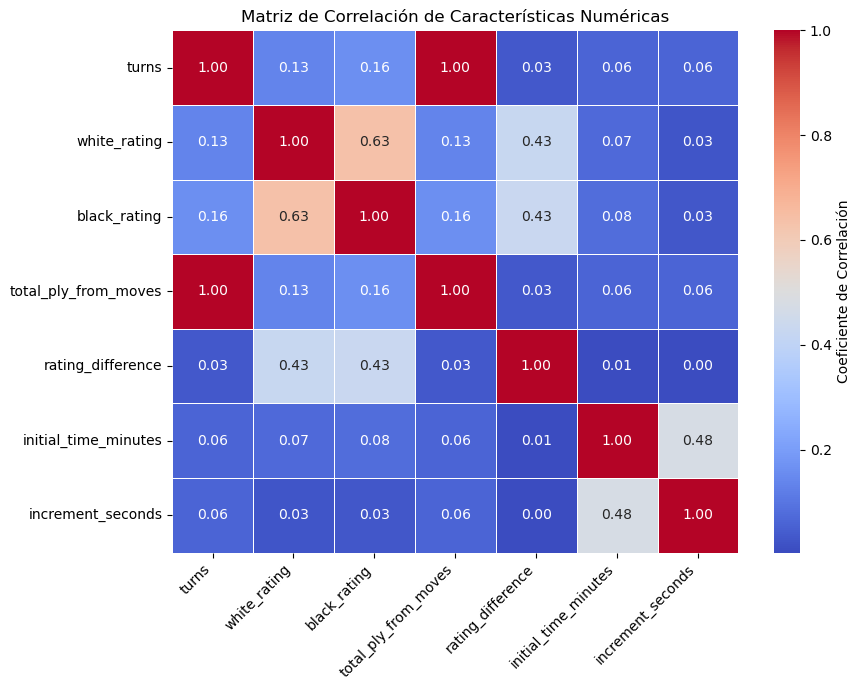

In [5]:
#Ahora que tenemos las columnas que necesitamos limpias, vamos a ver si las necesitamos todas:
#Vamso a hacer un heatmap para ver su correlacion:
numeric_cols = [
    'turns',
    'white_rating',
    'black_rating',
    'total_ply_from_moves',
    'rating_difference',
    'initial_time_minutes',
    'increment_seconds'
]

corr = np.abs(df_chess[numeric_cols].corr())

plt.figure(figsize=(9, 7)) 
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar_kws={'label': 'Coeficiente de Correlación'})
plt.title('Matriz de Correlación de Características Numéricas')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Vemos que turns y total_ply_from_moves tienen una correlación perfecta, pero la segunda que he creado, total_ply_from_moves es una medida que representa cada medio movimientoy la utilice para confirmar que los datos estaban bien sacando la infromación del conjunto de movimientos, que es la fuente completa de la partida.
total_ply_from_moves es una característica mejor para la duración de la partida.

In [6]:
df_chess.drop(columns=['turns'], inplace=True)

In [7]:
# Pasemos a codificar las variables categóricas:
df_chess = pd.get_dummies(df_chess, columns=['victory_status', 'rated'], drop_first=True)

In [8]:
# Podemos ya definir nuestro target.
features = df_chess.drop(columns='winner')
target = df_chess['winner']
# Después codificamos el target.
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(target)
# Dividimos los datos.
x_train, x_test, y_train, y_test = train_test_split(features, y_encoded, test_size=0.20, random_state=42)
# Normalizamos las características numéricas para asegurar que todas las variables tengan una escala comparable
x_train_norm, x_test_norm, scaler_fitted = normalize_features(x_train, x_test, normalizer=MinMaxScaler())

<h2 style="color: 	#80B1D3;"><strong>Modelos machine learning</strong></h2>

Fitting 5 folds for each of 30 candidates, totalling 150 fits

Mejor K (n_neighbors) encontrado: 29

--- Evaluación del Modelo K-NN con el Mejor K ---

Rendimiento en el Conjunto de ENTRENAMIENTO:
Reporte de Clasificación (Entrenamiento):
               precision    recall  f1-score   support

       black       0.66      0.64      0.65      7130
        draw       1.00      0.95      0.97       740
       white       0.68      0.71      0.69      7819

    accuracy                           0.69     15689
   macro avg       0.78      0.77      0.77     15689
weighted avg       0.69      0.69      0.69     15689


Rendimiento en el Conjunto de PRUEBA:
Reporte de Clasificación (Prueba):
               precision    recall  f1-score   support

       black       0.62      0.59      0.60      1787
        draw       1.00      0.96      0.98       178
       white       0.64      0.67      0.66      1958

    accuracy                           0.65      3923
   macro avg       0.75      0.7

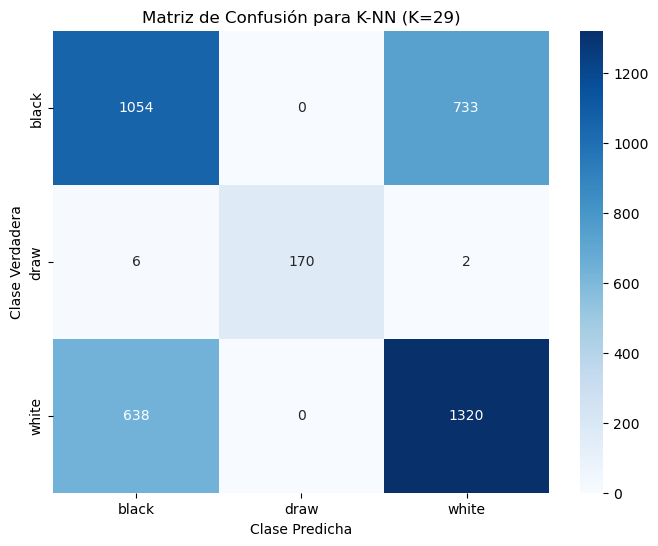

In [ ]:
# Anteriormente probé el modelo KNN pero con una evaluación de entrenamiento mayor a la de prueba indicando overfitting.
#  De nuevo pero con el grid search para ver si lo incorrecto eran nustros parametros.
param_grid = {'n_neighbors': np.arange(1, 31)} # Prueba de K=1 a K=30

# Inicializar el modelo KNN
knn = KNeighborsClassifier()

# Configuramos y ejecutamos:
# cv=5: Usa 5-fold cross-validation
# n_jobs=-1: Utiliza todos los núcleos de la CPU para acelerar el proceso
# verbose=1: Muestra información durante la ejecución
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(x_train_norm, y_train)
best_k = grid_search.best_params_['n_neighbors']
print(f"\nMejor K (n_neighbors) encontrado: {best_k}")

# Entrenamos el modelo KNN final con el mejor K encontrado
best_knn_model = grid_search.best_estimator_

# Realizamos predicciones en ambos conjuntos
y_train_pred_best_knn = best_knn_model.predict(x_train_norm)
y_test_pred_best_knn = best_knn_model.predict(x_test_norm)
print("\n--- Evaluación del Modelo K-NN con el Mejor K ---")

# Evaluación en el conjunto de ENTRENAMIENTO
print("\nRendimiento en el Conjunto de ENTRENAMIENTO:")
print("Reporte de Clasificación (Entrenamiento):\n", classification_report(y_train, y_train_pred_best_knn, target_names=label_encoder.classes_))

# Evaluación en el conjunto de PRUEBA
print("\nRendimiento en el Conjunto de PRUEBA:")
print("Reporte de Clasificación (Prueba):\n", classification_report(y_test, y_test_pred_best_knn, target_names=label_encoder.classes_))

# Matriz de Confusión para el conjunto de prueba
print("\nMatriz de Confusión (Conjunto de Prueba):")
cm_best_knn = confusion_matrix(y_test, y_test_pred_best_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best_knn, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f'Matriz de Confusión para K-NN (K={best_k})')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.show()

- Hemos probado el modelo K-Nearest Neighbors (KNN), que es un buen punto de partida por su simplicidad.
- Inicialmente, con K=5, observamos un sobreajuste significativo (una gran diferencia entre el rendimiento en entrenamiento y en prueba).
- Optimizamos el valor de K usando GridSearchCV encontrando un K óptimo de 29.
- Con el K optimizado, logramos reducir el sobreajuste (la brecha entre entrenamiento y prueba se hizo mucho más pequeña), lo cual es una mejora importante en la capacidad de generalización del modelo.
- Sin embargo, la precisión general en el conjunto de prueba mejoró solo infimamente (del 63% al 65%). Además, el modelo sigue teniendo dificultades para distinguir entre las victorias de "Black" y "White", aunque es excelente prediciendo "Draws".

Fitting 5 folds for each of 81 candidates, totalling 405 fits

Mejores hiperparámetros encontrados para Árbol de Decisión: {'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 10}

Rendimiento en el Conjunto de ENTRENAMIENTO:
Reporte de Clasificación (Entrenamiento):
               precision    recall  f1-score   support

       black       0.68      0.63      0.65      7130
        draw       0.99      0.91      0.94       740
       white       0.68      0.74      0.71      7819

    accuracy                           0.70     15689
   macro avg       0.78      0.76      0.77     15689
weighted avg       0.70      0.70      0.70     15689


Rendimiento en el Conjunto de PRUEBA:
Reporte de Clasificación (Prueba):
               precision    recall  f1-score   support

       black       0.66      0.59      0.62      1787
        draw       0.96      0.90      0.93       178
       white       0.66      0.72      0.69      1958

    accuracy                           0.67      

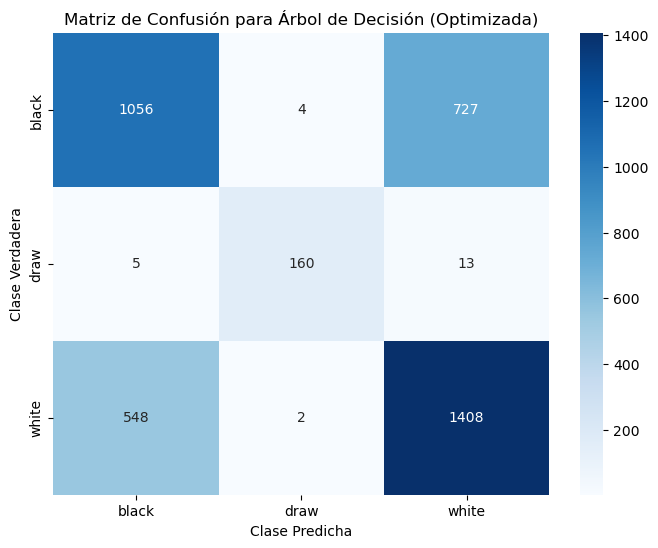

In [19]:
#Continuemos con otro modelo
#Decision Tree:
dt = DecisionTreeClassifier(random_state=42)

# Vamos a aplicar el grisSearch en este tambien, se habia aprendido a la perfecttión el modelo de entrenamiento.
param_grid_dt = {
    'max_depth': np.arange(3, 21, 2),
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 3, 5]    
}

# Configurar y Ejecutar GridSearchCV
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Entrenar el modelo
grid_search_dt.fit(x_train_norm, y_train)

# Mejor resultado
best_params_dt = grid_search_dt.best_params_
print(f"\nMejores hiperparámetros encontrados para Árbol de Decisión: {best_params_dt}")

# Accedemos al modelo mejor entrenado
best_dt_model = grid_search_dt.best_estimator_

# Realizamos predicciones en ambos conjuntos
y_train_pred_best_dt = best_dt_model.predict(x_train_norm)
y_test_pred_best_dt = best_dt_model.predict(x_test_norm)

# Evaluación en el conjunto de ENTRENAMIENTO
print("\nRendimiento en el Conjunto de ENTRENAMIENTO:")
print("Reporte de Clasificación (Entrenamiento):\n", classification_report(y_train, y_train_pred_best_dt, target_names=label_encoder.classes_))

# Evaluación en el conjunto de PRUEBA
print("\nRendimiento en el Conjunto de PRUEBA:")
print("Reporte de Clasificación (Prueba):\n", classification_report(y_test, y_test_pred_best_dt, target_names=label_encoder.classes_))

# Matriz de Confusión para el conjunto de prueba
print("\nMatriz de Confusión (Conjunto de Prueba):")
cm_best_dt = confusion_matrix(y_test, y_test_pred_best_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best_dt, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f'Matriz de Confusión para Árbol de Decisión (Optimizada)')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.show()

- El rendimiento es bastante similar al KNN optimizado, alrededor del 60-70%. La confusión entre black y white persiste.

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Mejores hiperparámetros encontrados para Bagging: {'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100}

Rendimiento en el Conjunto de ENTRENAMIENTO:
Reporte de Clasificación (Entrenamiento):
               precision    recall  f1-score   support

       black       0.74      0.72      0.73      7130
        draw       1.00      0.91      0.95       740
       white       0.75      0.78      0.76      7819

    accuracy                           0.76     15689
   macro avg       0.83      0.80      0.82     15689
weighted avg       0.76      0.76      0.76     15689


Rendimiento en el Conjunto de PRUEBA:
Reporte de Clasificación (Prueba):
               precision    recall  f1-score   support

       black       0.67      0.64      0.66      1787
        draw       0.99      0.90      0.94       178
       white       0.68      0.71      0.70      1958

    accuracy                           0.69      3923
   macro

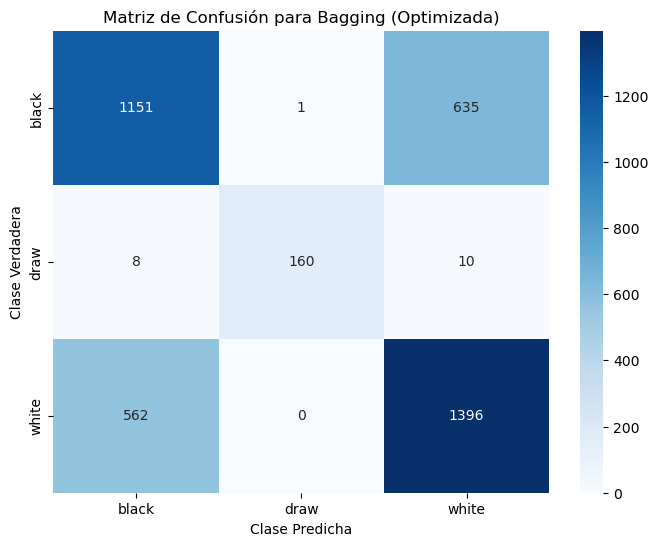

In [21]:
# Ahora vamos con los métodos de conjunto:
# Vamos a usar el modelo optimizado de el arbol de decision anterior 
base_estimator = best_dt_model

# Inicializar el clasificador Bagging
bagging_model = BaggingClassifier(estimator=base_estimator, random_state=42)

# Ahora, solo necesitamos optimizar los parámetros propios de Bagging.
param_grid_bagging = {
    'n_estimators': [10, 50, 100], # Prueba 10, 50, 100 árboles
    'max_samples': [0.7, 1.0],     # Usa el 70% o el 100% de las muestras
    'max_features': [0.7, 1.0]     # Usa el 70% o el 100% de las características
}

grid_search_bagging = GridSearchCV(bagging_model, param_grid_bagging, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Ejecutamos la búsqueda en el conjunto de entrenamiento
grid_search_bagging.fit(x_train_norm, y_train)

# Mostramos los mejores resultados
best_params_bagging = grid_search_bagging.best_params_
print(f"\nMejores hiperparámetros encontrados para Bagging: {best_params_bagging}")

# Accede directamente al mejor modelo entrenado por GridSearchCV
best_bagging_model = grid_search_bagging.best_estimator_

# Realizamos predicciones en ambos conjuntos
y_train_pred_best_bagging = best_bagging_model.predict(x_train_norm)
y_test_pred_best_bagging = best_bagging_model.predict(x_test_norm)

# Evaluación en el conjunto de ENTRENAMIENTO
print("\nRendimiento en el Conjunto de ENTRENAMIENTO:")
print("Reporte de Clasificación (Entrenamiento):\n", classification_report(y_train, y_train_pred_best_bagging, target_names=label_encoder.classes_))

# Evaluación en el conjunto de PRUEBA
print("\nRendimiento en el Conjunto de PRUEBA:")
print("Reporte de Clasificación (Prueba):\n", classification_report(y_test, y_test_pred_best_bagging, target_names=label_encoder.classes_))

# Matriz de Confusión para el conjunto de prueba
print("\nMatriz de Confusión (Conjunto de Prueba):")
cm_best_bagging = confusion_matrix(y_test, y_test_pred_best_bagging)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best_bagging, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f'Matriz de Confusión para Bagging (Optimizada)')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.show()

- Hay una mejora marginal en el F1-Score para ambas clases (66% y 70% respectivamente), lo cual es bueno. Siguen siendo las clases donde el modelo lucha más, pero se ve una tendencia a la mejora.
- El Bagging ha logrado una Accuracy de prueba del 69%, que es la más alta que hemos visto hasta ahora.

Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\rocio\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



Mejores hiperparámetros encontrados para AdaBoost: {'learning_rate': 0.1, 'n_estimators': 100}

Rendimiento en el Conjunto de ENTRENAMIENTO:
Reporte de Clasificación (Entrenamiento):
               precision    recall  f1-score   support

       black       0.65      0.57      0.61      7130
        draw       1.00      0.95      0.98       740
       white       0.65      0.73      0.69      7819

    accuracy                           0.67     15689
   macro avg       0.77      0.75      0.76     15689
weighted avg       0.67      0.67      0.67     15689


Rendimiento en el Conjunto de PRUEBA:
Reporte de Clasificación (Prueba):
               precision    recall  f1-score   support

       black       0.66      0.58      0.61      1787
        draw       1.00      0.96      0.98       178
       white       0.65      0.73      0.69      1958

    accuracy                           0.67      3923
   macro avg       0.77      0.75      0.76      3923
weighted avg       0.67      0.67

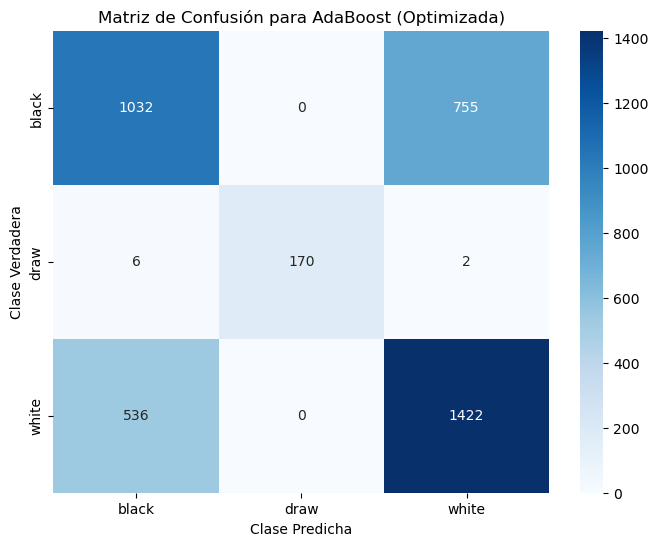

In [25]:
# AdaBoost está diseñado para funcionar mejor con clasificadores base muy simples y "débiles".
# Si los árboles base fueran ya muy complejos y buenos (como nuestro best_dt_model con max_depth=9) 
# tendrían muy pocos errores en los que concentrarse, y el proceso de boosting sería menos efectivo
# Usaremos entonces uno muy simple y no el que teniamos evitando el overfitting:
base_estimator_ada = DecisionTreeClassifier(max_depth=1, random_state=42)

# Inicializamos el clasificador AdaBoost
ada_model = AdaBoostClassifier(estimator=base_estimator_ada, random_state=42)

# Definimos la cuadrícula de parámetros para AdaBoost
param_grid_ada = {
    'n_estimators': [50, 100, 200], # Prueba 50, 100, 200 árboles base
    'learning_rate': [0.01, 0.1, 1.0] # Prueba diferentes tasas de aprendizaje
}

# Definimos
grid_search_ada = GridSearchCV(ada_model, param_grid_ada, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Ejecutamos la búsqueda en el conjunto de entrenamiento
grid_search_ada.fit(x_train_norm, y_train)

# Mostrar los Mejores Resultados de GridSearchCV
best_params_ada = grid_search_ada.best_params_
print(f"\nMejores hiperparámetros encontrados para AdaBoost: {best_params_ada}")

# Los usamos
best_ada_model = grid_search_ada.best_estimator_

# Realizamos predicciones en ambos conjuntos
y_train_pred_best_ada = best_ada_model.predict(x_train_norm)
y_test_pred_best_ada = best_ada_model.predict(x_test_norm)

# Evaluación en el conjunto de ENTRENAMIENTO
print("\nRendimiento en el Conjunto de ENTRENAMIENTO:")
print("Reporte de Clasificación (Entrenamiento):\n", classification_report(y_train, y_train_pred_best_ada, target_names=label_encoder.classes_))

# Evaluación en el conjunto de PRUEBA
print("\nRendimiento en el Conjunto de PRUEBA:")
print("Reporte de Clasificación (Prueba):\n", classification_report(y_test, y_test_pred_best_ada, target_names=label_encoder.classes_))

# Matriz de Confusión para el conjunto de prueba
print("\nMatriz de Confusión (Conjunto de Prueba):")
cm_best_ada = confusion_matrix(y_test, y_test_pred_best_ada)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best_ada, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f'Matriz de Confusión para AdaBoost (Optimizada)')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.show()

- La brecha entre entrenamiento y prueba es 0 lo que indica un modelo extremadamente bien generalizado y sin sobreajuste.
- Pero el rendimiento es similar a los modelos anteriores, con F1-Scores de 0.61 para 'black' y 0.69 para 'white'. La confusión entre estas dos clases persiste.

Fitting 5 folds for each of 18 candidates, totalling 90 fits

Mejores hiperparámetros encontrados para Gradient Boosting: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}

Rendimiento en el Conjunto de ENTRENAMIENTO:
Reporte de Clasificación (Entrenamiento):
               precision    recall  f1-score   support

       black       0.95      0.94      0.95      7130
        draw       1.00      1.00      1.00       740
       white       0.95      0.95      0.95      7819

    accuracy                           0.95     15689
   macro avg       0.97      0.97      0.97     15689
weighted avg       0.95      0.95      0.95     15689


Rendimiento en el Conjunto de PRUEBA:
Reporte de Clasificación (Prueba):
               precision    recall  f1-score   support

       black       0.89      0.87      0.88      1787
        draw       0.99      0.96      0.97       178
       white       0.89      0.90      0.89      1958

    accuracy                           0.89      3923
 

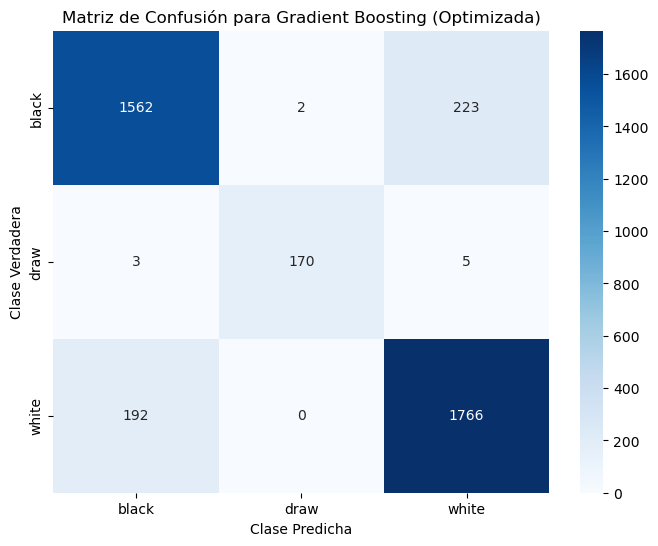

In [28]:
# Inicializamos el clasificador Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)

# Definimos la cuadrícula de parámetros para Gradient Boosting
param_grid_gb = {
    'n_estimators': [50, 100, 200],      # Número de árboles
    'learning_rate': [0.01, 0.1, 0.2],  # Tasa de aprendizaje
    'max_depth': [3, 5]                 # Profundidad máxima de cada árbol base
}

grid_search_gb = GridSearchCV(gb_model, param_grid_gb, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
# Ejecutamos la búsqueda en el conjunto de entrenamiento
grid_search_gb.fit(x_train_norm, y_train)

# Mostrar los Mejores Resultados de GridSearchCV
best_params_gb = grid_search_gb.best_params_
print(f"\nMejores hiperparámetros encontrados para Gradient Boosting: {best_params_gb}")

# Accede directamente al mejor modelo entrenado por GridSearchCV
best_gb_model = grid_search_gb.best_estimator_

# Realizamos predicciones en ambos conjuntos
y_train_pred_best_gb = best_gb_model.predict(x_train_norm)
y_test_pred_best_gb = best_gb_model.predict(x_test_norm)

# Evaluación en el conjunto de ENTRENAMIENTO
print("\nRendimiento en el Conjunto de ENTRENAMIENTO:")
print("Reporte de Clasificación (Entrenamiento):\n", classification_report(y_train, y_train_pred_best_gb, target_names=label_encoder.classes_))

# Evaluación en el conjunto de PRUEBA
print("\nRendimiento en el Conjunto de PRUEBA:")
print("Reporte de Clasificación (Prueba):\n", classification_report(y_test, y_test_pred_best_gb, target_names=label_encoder.classes_))

# Matriz de Confusión para el conjunto de prueba
print("\nMatriz de Confusión (Conjunto de Prueba):")
cm_best_gb = confusion_matrix(y_test, y_test_pred_best_gb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best_gb, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f'Matriz de Confusión para Gradient Boosting (Optimizada)')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.show()

- Después de explorar varios algoritmos, desde el sencillo KNN hasta los potentes métodos de conjunto, el Gradient Boosting Classifier es el claro ganador para predecir el resultado de tus partidas de ajedrez.
- Iniciamos con modelos que apenas superaban el 65% de precisión, lidiando con un molesto sobreajuste y una gran confusión entre las victorias de "black" y "white". Si bien AdaBoost logró un modelo perfectamente equilibrado, no alcanzó la precisión deseada.
- Las predicciones de empate son casi perfectas, y, crucialmente, hemos reducido drásticamente la confusión entre las victorias de "black" y "white". Los errores mutuos entre estas clases han bajado significativamente, indicando que el modelo ahora entiende mucho mejor los patrones subyacentes de cada resultado.